# LIDC-IDRI Lung Segmentation


In [1]:
%pip install -q segmentation_models
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import cv2
import keras
import datasets
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models as sm

sm.set_framework("tf.keras")
sm.framework()

from PIL import Image
from dataclasses import dataclass
from keras.metrics import Accuracy, Recall, Precision, AUC

from segmentation_models import Unet, get_preprocessing
from segmentation_models.losses import BinaryFocalLoss, jaccard_loss
from segmentation_models.metrics import iou_score, f1_score

Segmentation Models: using `tf.keras` framework.


Load the dataset


In [3]:
lung_dataset = datasets.load_dataset("jmanuelc87/lidc-idri-segmentation")
lung_dataset = lung_dataset["train"].train_test_split(train_size=0.8, seed=42)  # type: ignore
lung_dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 2120
    })
    test: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 531
    })
})

## Configuration


In [4]:
@dataclass
class TrainingConfig:
    EPOCHS: int = 20
    NUM_CLASSES: int = 1
    BATCH_SIZE: int = 8
    IMG_WIDTH: int = 448
    IMG_HEIGHT: int = 448

## Visualization

Exploration of some samples of the dataset and its masks


In [5]:
def num_to_rgb(mask):
    num_arr = np.array(mask)
    output = np.zeros(num_arr.shape[:2] + (3,))
    output[num_arr == 255] = (255, 0, 0)
    return output.astype(np.uint8)

In [6]:
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

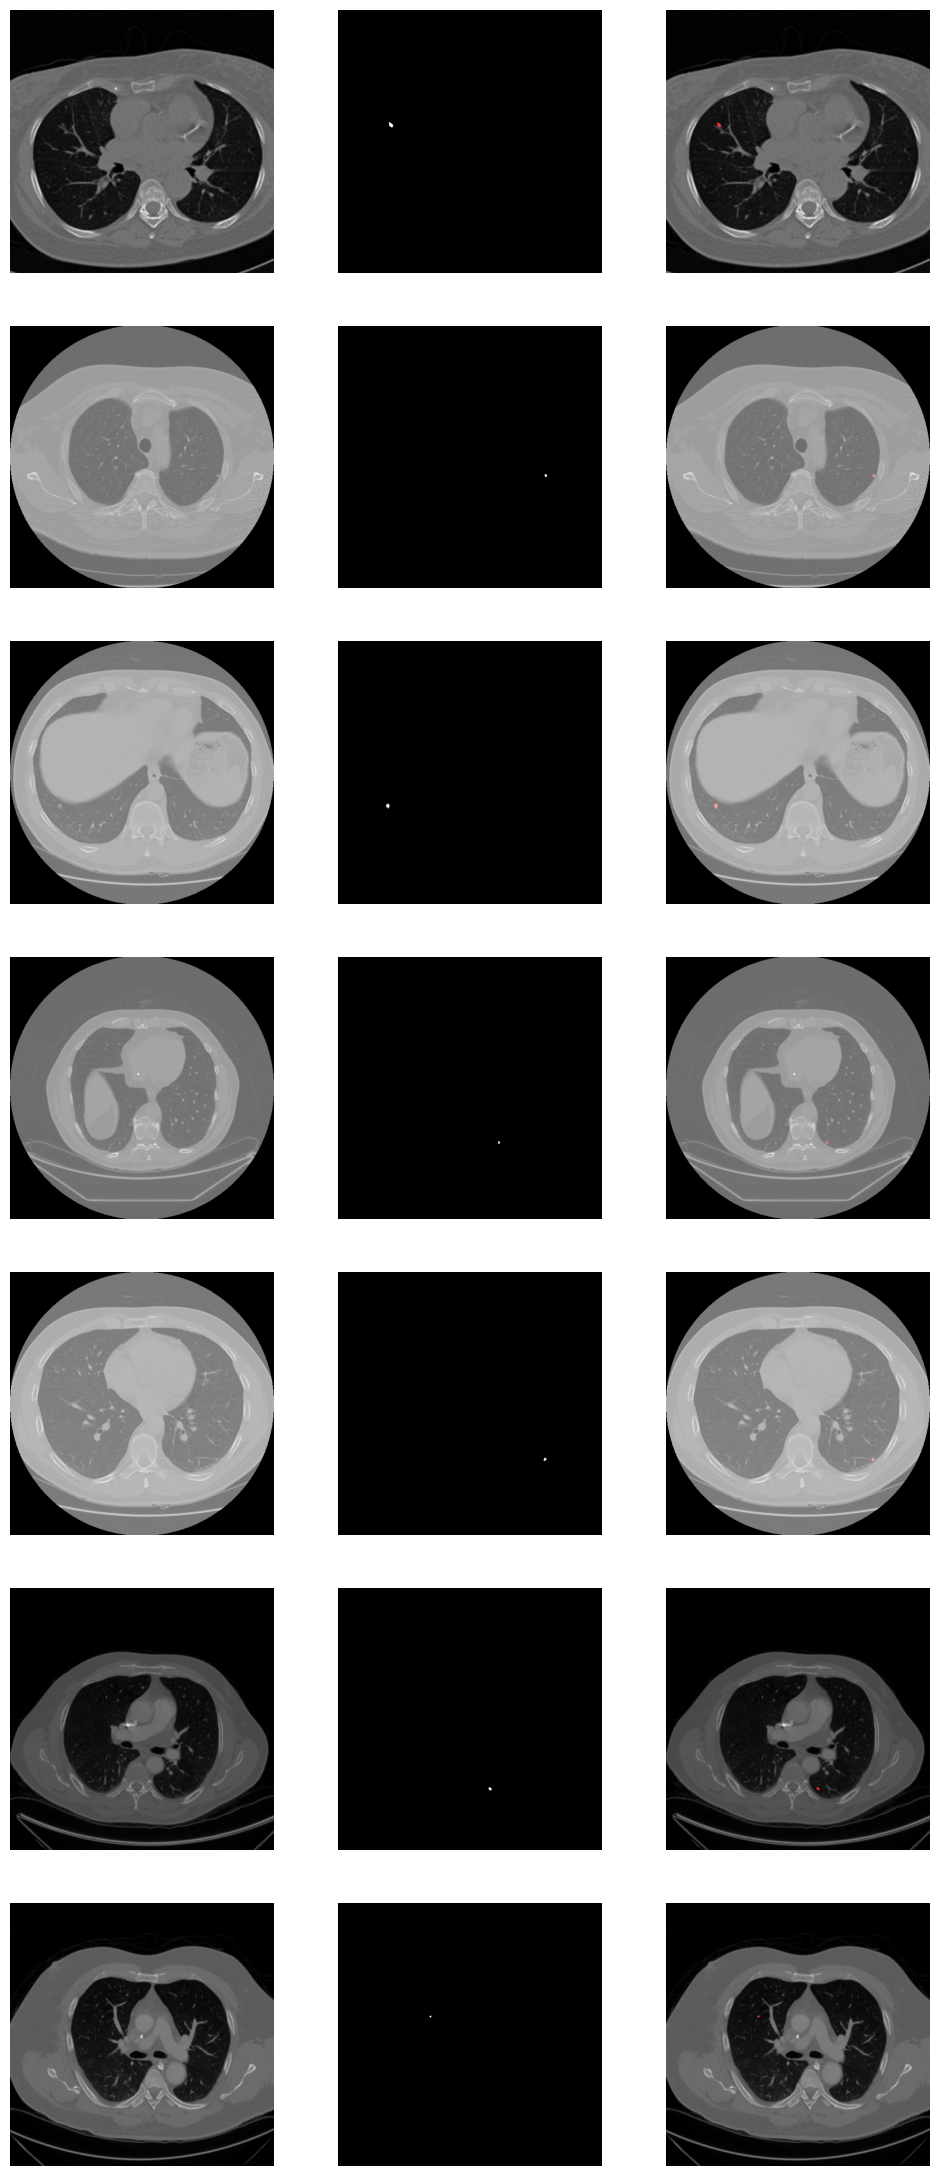

In [7]:
def plot(dataset: datasets.Dataset, qty=10):
    fig, ax = plt.subplots(qty, 3, figsize=(12, 28))

    for i, item in enumerate(dataset):
        if i >= qty:
            break

        ax[i, 0].axis("off")
        ax[i, 0].imshow(item["image"], cmap="gray")  # type: ignore

        ax[i, 1].axis("off")
        ax[i, 1].imshow(item["image_mask"], cmap="gray")  # type: ignore

        patch = np.array(item["image"])  # type: ignore
        patch = np.transpose(np.stack([patch, patch, patch]), axes=(1, 2, 0))

        mask = num_to_rgb(item["image_mask"])  # type: ignore
        image = image_overlay(patch, mask)

        ax[i, 2].axis("off")
        ax[i, 2].imshow(image, cmap="gray")


plot(lung_dataset["train"], qty=7)  # type: ignore

## Data Preparation

Preparation of the dataset using albumentations library for augmenting the dataset samples using the transformations:

- RandomCrop
- CenterCrop
- SquareSymmetry
- GaussNoise
- Normalize
- ToTensor

And creation of the train, valid and test splits for datasets and dataloaders


In [8]:
train_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            interpolation=cv2.INTER_LINEAR,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)


valid_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)

preprocess_fn = get_preprocessing("resnet50")

In [9]:
def map_image_transforms(transformations):

    def wrapper(row):
        augmented = []
        keys = row.keys()
        for item in zip(*row.values()):
            items = {k: np.array(v) for k, v in zip(keys, item)}
            values = transformations(**items)
            augmented.append(values)

        key = "image"
        row[key] = [
            np.transpose(
                np.stack([item[key], item[key], item[key]]),
                axes=(1, 2, 0),
            ).astype(np.float32)
            for item in augmented
        ]

        row["mask"] = [np.array(item["mask"])[:,:,np.newaxis].astype(np.float32) for item in augmented]

        return row

    return wrapper

In [10]:
# Remove the columns not needed and rename the ones needed to be interpreted by albumentations library
new_lung_dataset = (
    lung_dataset.remove_columns(["patch", "patch_mask", "malignancy", "cancer"])
    .rename_column("image_mask", "mask")
)

In [11]:
def create_datasets(lung_dataset):
    lung_train_dataset = (
        lung_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(train_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
            shuffle=True,
        )
    )

    tmp_dataset = lung_dataset["test"].train_test_split(train_size=0.5)

    lung_valid_dataset = (
        tmp_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
            shuffle=True,
        )
    )

    lung_test_dataset = (
        tmp_dataset["test"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
            shuffle=True,
        )
    )

    return lung_train_dataset, lung_valid_dataset, lung_test_dataset

In [12]:
(
    train_dataset,
    valid_dataset,
    test_dataset,
) = create_datasets(new_lung_dataset)

## Modeling

Creation of a UNet model in pytorch


In [13]:
binary_focal_loss = BinaryFocalLoss(gamma=0.0)


def loss(y_true, y_pred):

    IoU = jaccard_loss(y_true, y_pred)

    FOCAL = binary_focal_loss(y_true, y_pred)

    return IoU + FOCAL

In [14]:
model = Unet(
    backbone_name="resnet50",
    encoder_weights='imagenet',
    input_shape=(None, None, 3),
    classes=TrainingConfig.NUM_CLASSES,
)

model.compile(
    loss=loss,
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    metrics=[iou_score, f1_score],
)

In [15]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_iou_score", mode="max", patience=2, restore_best_weights=True, verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=TrainingConfig.EPOCHS,
    batch_size=TrainingConfig.BATCH_SIZE,
    callbacks=[early_stop],
)

Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 159s 302ms/step - f1-score: 0.1729 - iou_score: 0.0969 - loss: 1.3992 - val_f1-score: 0.1553 - val_iou_score: 0.0859 - val_loss: 1.4163
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 71s 266ms/step - f1-score: 0.1956 - iou_score: 0.1113 - loss: 1.3636 - val_f1-score: 0.1546 - val_iou_score: 0.0852 - val_loss: 1.4490
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 70s 266ms/step - f1-score: 0.2063 - iou_score: 0.1181 - loss: 1.3431 - val_f1-score: 0.1632 - val_iou_score: 0.0899 - val_loss: 1.4118
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 70s 265ms/step - f1-score: 0.2130 - iou_score: 0.1225 - loss: 1.3258 - val_f1-score: 0.1714 - val_iou_score: 0.0956 - val_loss: 1.3699
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 71s 266ms/step - f1-score: 0.2215 - iou_score: 0.1285 - loss: 1.3046 - val_f1-score: 0.1978 - val_iou_score: 0.1124 - val_loss: 1.3312
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 70s 266ms/step - f1-score: 0.2679 - iou_score: 0.1612 - loss: 1.2304 - val_f1-score:

In [16]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [
            metrics,
        ]
        metric_name = [
            metric_name,
        ]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])  # type:ignore

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)  # type:ignore
    plt.title(ylabel)  # type:ignore
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=True)
    plt.close()

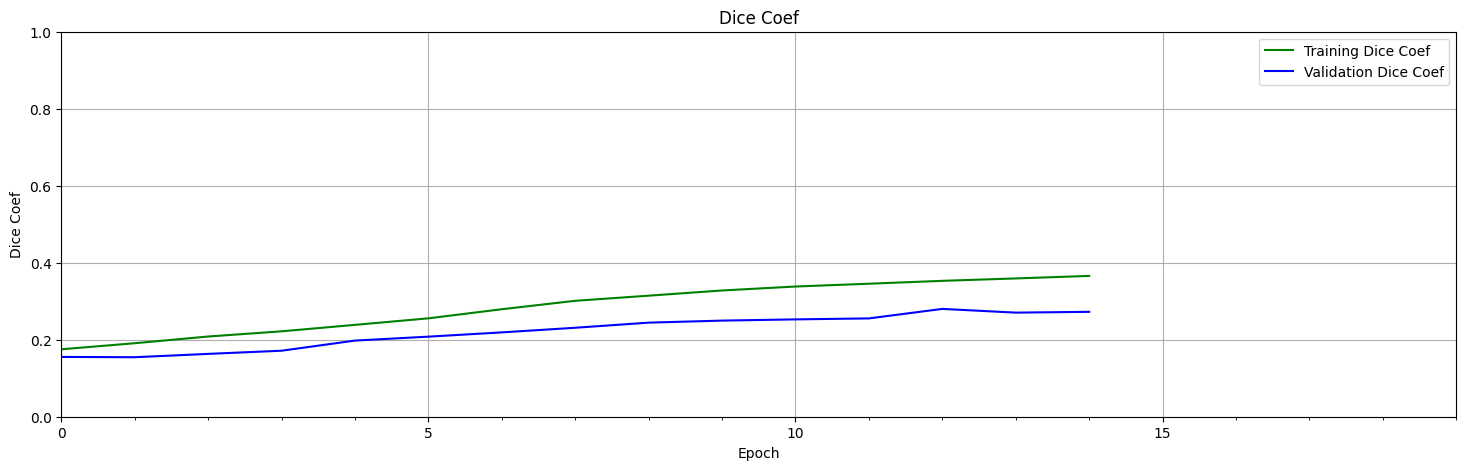

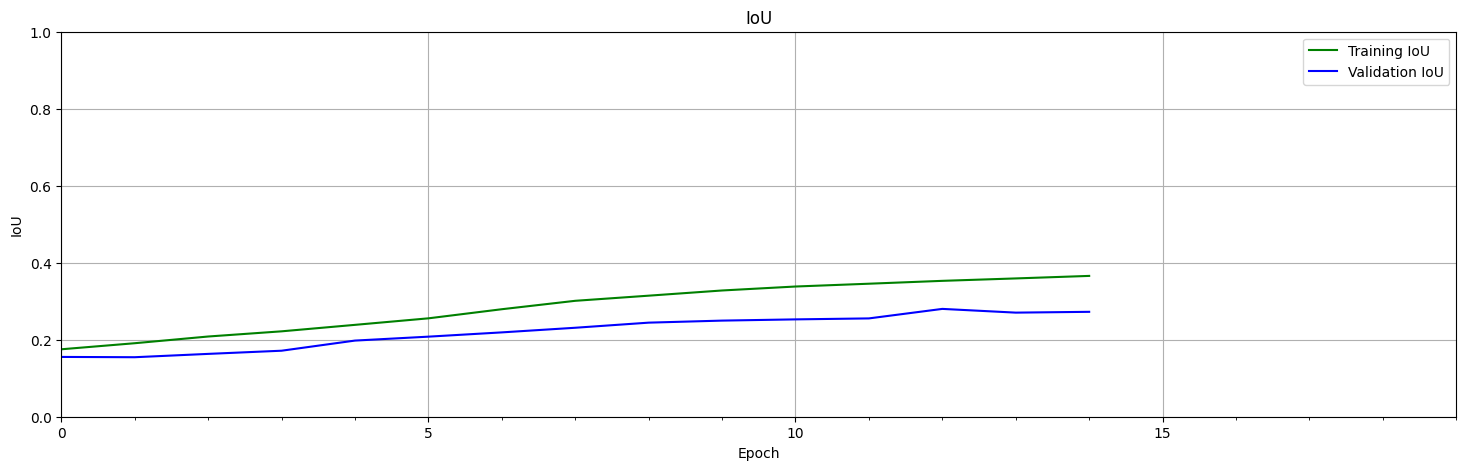

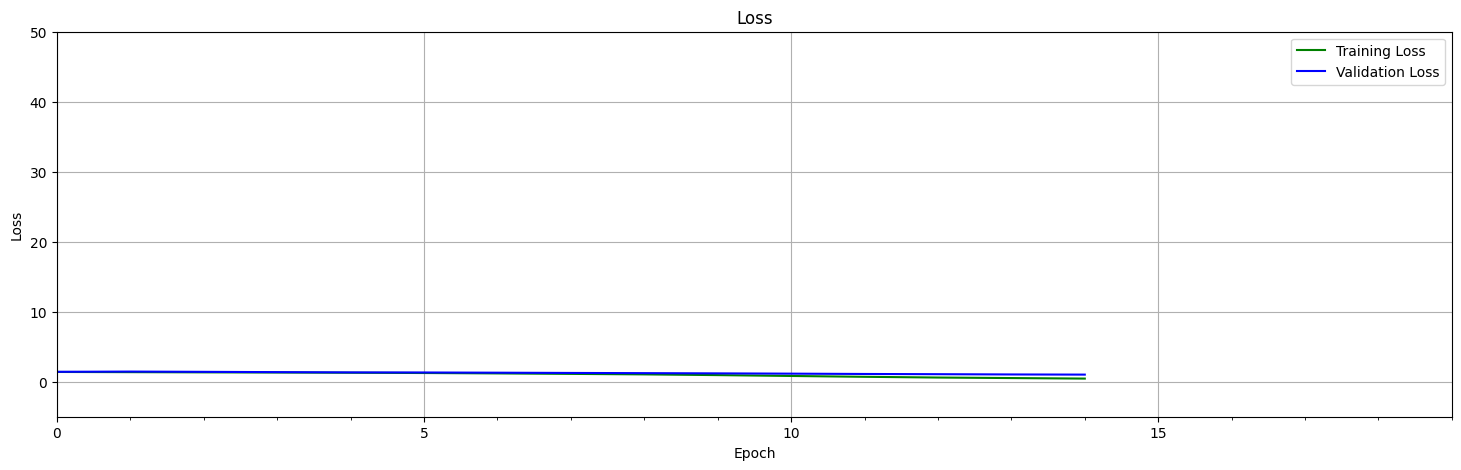

In [17]:
train_dice = history.history["f1-score"]
valid_dice = history.history["val_f1-score"]

# Dice coefficient.
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

# IoU Score
train_iou = history.history["iou_score"]
valid_iou = history.history["val_iou_score"]


plot_results(
    [train_dice, valid_dice],
    ylabel="Dice Coef",
    ylim=[0.0, 1.0],
    metric_name=["Training Dice Coef", "Validation Dice Coef"],
    color=["g", "b"],
)

plot_results(
    [train_dice, valid_dice],
    ylabel="IoU",
    ylim=[0.0, 1.0],
    metric_name=["Training IoU", "Validation IoU"],
    color=["g", "b"],
)

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[-5.0, 50.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

In [18]:
def inference(model, dataset):

    num_batches_to_process = 1
    tf.experimental.numpy.experimental_enable_numpy_behavior()

    for idx, data in enumerate(dataset):

        if idx == num_batches_to_process:
            break

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype("float32")
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img * 255).astype("uint8")

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20, 8))

            # Display the original image.
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(batch_img[i], cmap="gray")
            ax1.title.set_text("Actual frame")
            plt.axis("off")

            # Display the ground truth mask.
            true_mask = batch_mask[i].astype(np.uint8)
            ax2 = fig.add_subplot(1, 4, 2)
            ax2.set_title("Ground truth labels")
            ax2.imshow(true_mask, cmap="gray")
            plt.axis("off")

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i][:, :, np.newaxis]

            pred_mask = np.where(pred_mask >= 0.1, 1., 0.).astype(np.uint8)

            ax3 = fig.add_subplot(1, 4, 3)
            ax3.set_title("Predicted labels")
            ax3.imshow(pred_mask, cmap="gray")
            plt.axis("off")

            plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


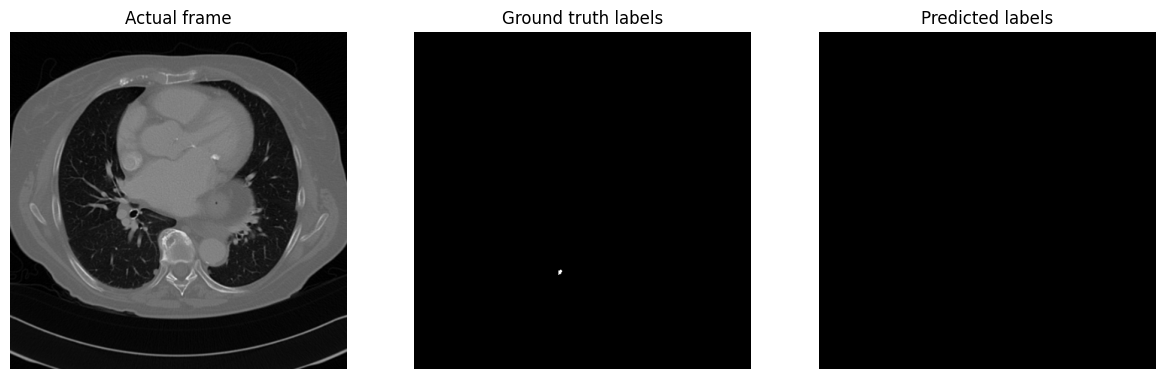

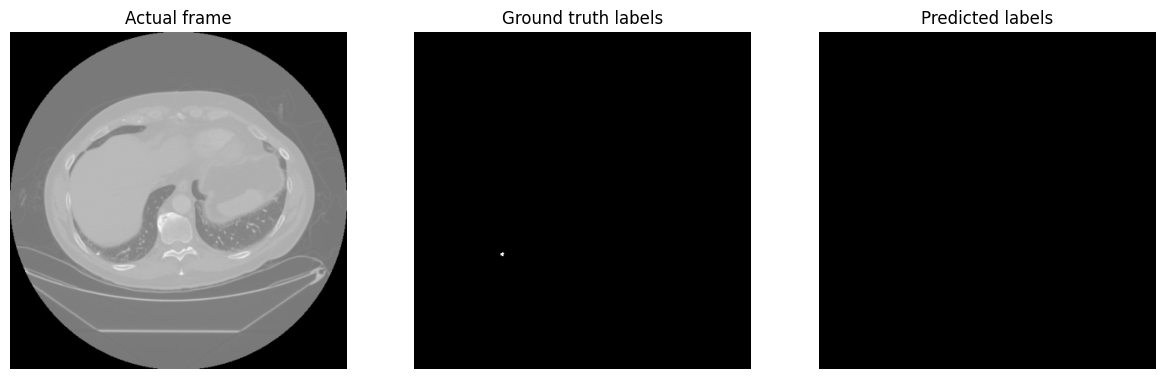

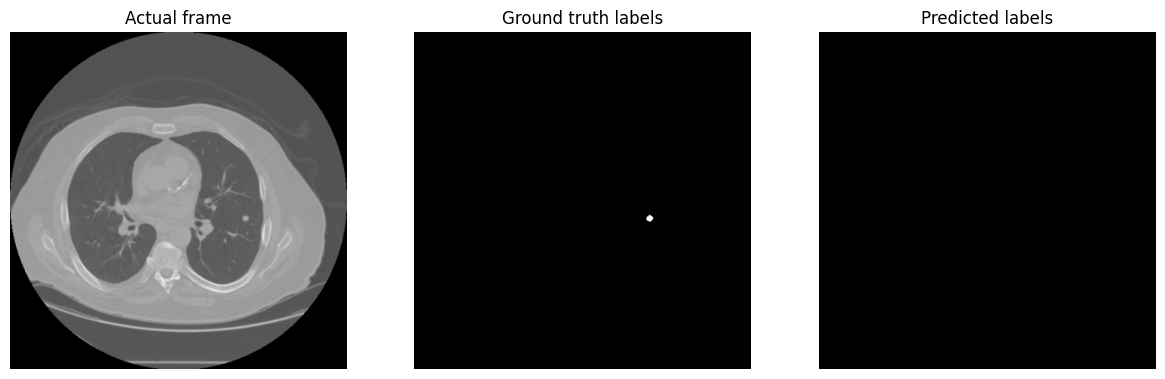

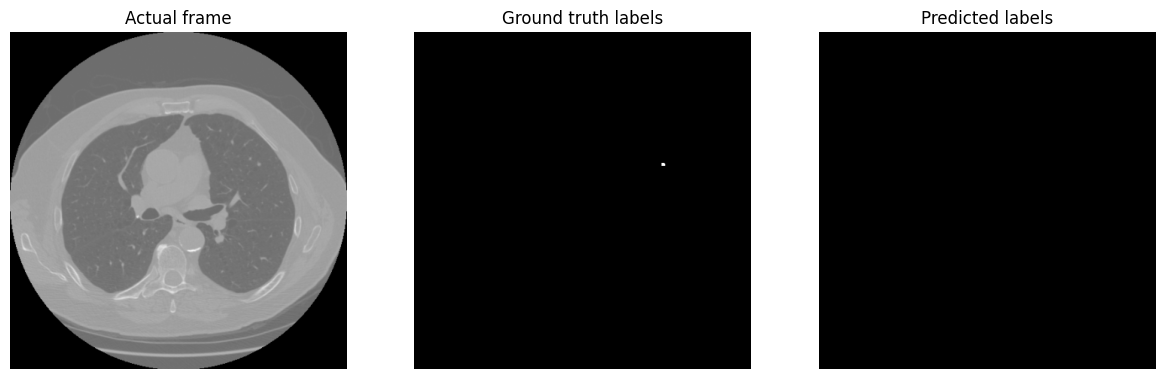

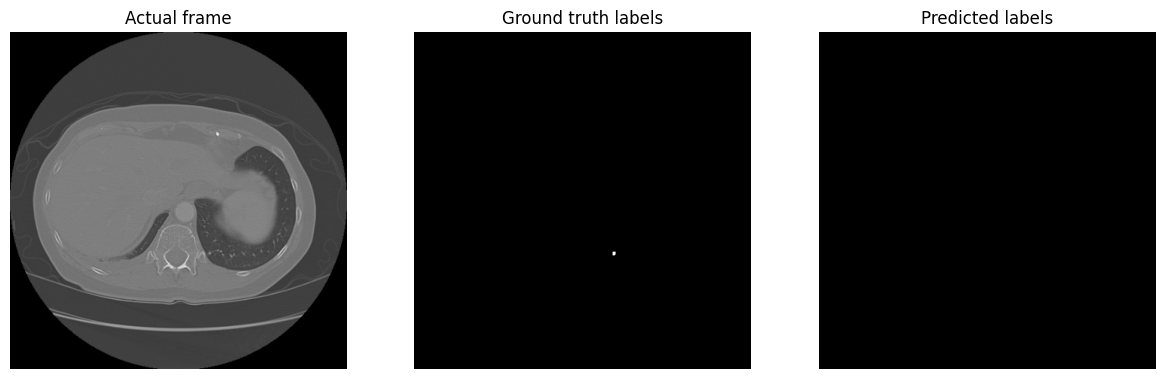

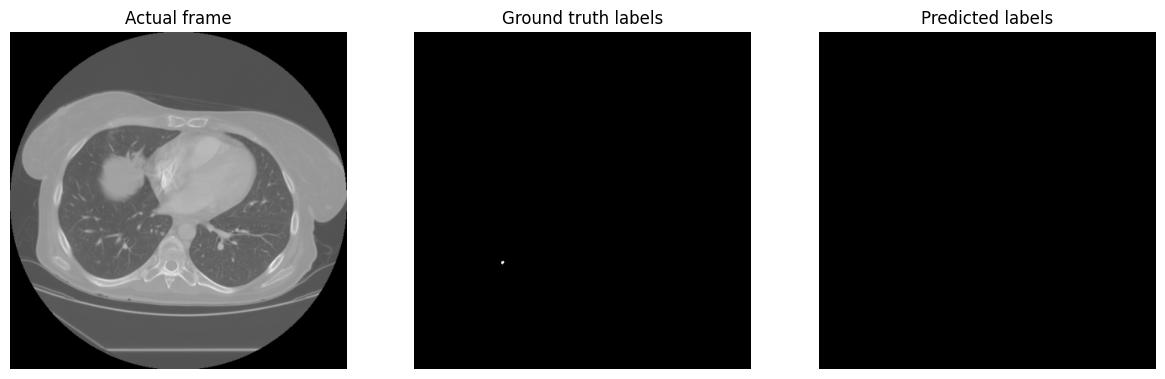

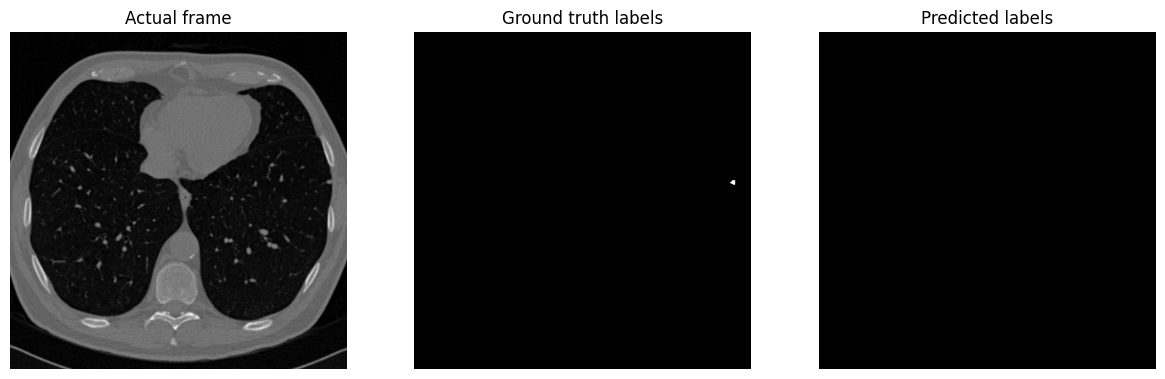

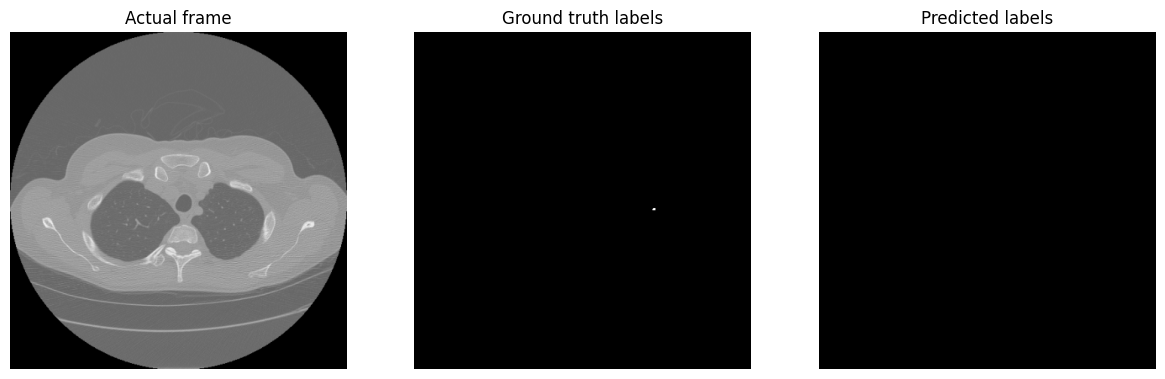

In [19]:
inference(model, test_dataset)